##Library

In [1]:
import pandas as pd
import json
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
!pip install spacy
!python -m spacy download en_core_web_sm

import pandas as pd
import nltk
from nltk.corpus import stopwords
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer
from spacy import displacy

import spacy.cli
spacy.cli.download("en_core_web_lg")
nlp = spacy.load("en_core_web_lg")


nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

2024-02-26 22:42:55.495371: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-26 22:42:55.546929: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-26 22:42:55.546974: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-26 22:42:55.548621: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-26 22:42:55.556734: I tensorflow/core/platform/cpu_feature_guar

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Data sorces and preprocessing

Data Loading

In [2]:
import pandas as pd

# Define file paths
business_file_path = '/content/drive/MyDrive/CIS_509/yelp_dataset/yelp_academic_dataset_business.csv'
review_file_path = '/content/drive/MyDrive/CIS_509/yelp_dataset/yelp_academic_dataset_review.csv'
user_file_path = '/content/drive/MyDrive/CIS_509/yelp_dataset/yelp_academic_dataset_user.csv'

# Load data from each file
business_df_from_csv = pd.read_csv(business_file_path)
df_from_review = pd.read_csv(review_file_path)
user_df_from_csv = pd.read_csv(user_file_path)

<ipython-input-2-9ebd5c8ff5b9>:11: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  user_df_from_csv = pd.read_csv(user_file_path)


List of top 20 cities

In [3]:
# Count the occurrences of each city in the 'city' column
city_counts = business_df_from_csv['city'].value_counts()

# Display the top 20 cities by business count
top_20_cities = city_counts.head(20)
print(top_20_cities)

city
Philadelphia        14569
Tucson               9250
Tampa                9050
Indianapolis         7540
Nashville            6971
New Orleans          6209
Reno                 5935
Edmonton             5054
Saint Louis          4827
Santa Barbara        3829
Boise                2937
Clearwater           2221
Saint Petersburg     1663
Metairie             1643
Sparks               1624
Wilmington           1446
Franklin             1414
St. Louis            1255
St. Petersburg       1185
Meridian             1043
Name: count, dtype: int64


In [4]:
import pandas as pd

# Assuming DataFrames df_from_review, business_df_from_csv, and user_df_from_csv are already loaded

# Convert 'date' column in df_from_review to datetime type for filtering
df_from_review['date'] = pd.to_datetime(df_from_review['date'])

# Filter businesses for 'restaurant' in 'categories'
restaurants_df = business_df_from_csv[business_df_from_csv['categories'].str.contains('Restaurant', case=False, na=False)]

# Define cities of interest
cities = ['Indianapolis', 'Tampa', 'Nashville']

# Initialize variables for each city's DataFrame
indianapolis_restaurants_reviews_df = pd.DataFrame()
tampa_restaurants_reviews_df = pd.DataFrame()
nashville_restaurants_reviews_df = pd.DataFrame()

# Filter and create DataFrames for each city
for city in cities:
    # Filter businesses by city
    city_businesses = restaurants_df[restaurants_df['city'] == city]

    # Filter reviews before 2020
    reviews_before_2020 = df_from_review[df_from_review['date'].dt.year < 2020]

    # Merge filtered reviews with city businesses on 'business_id'
    city_reviews = pd.merge(reviews_before_2020, city_businesses, on='business_id', how='inner')

    # Merge with user information from user_df_from_csv on 'user_id', if needed
    final_city_df = pd.merge(city_reviews, user_df_from_csv, on='user_id', how='left')

    # Assign the final DataFrame to the corresponding city variable
    if city == 'Indianapolis':
        indianapolis_restaurants_reviews_df = final_city_df
    elif city == 'Tampa':
        tampa_restaurants_reviews_df = final_city_df
    elif city == 'Nashville':
        nashville_restaurants_reviews_df = final_city_df

# Now you have three DataFrames:
# - indianapolis_restaurants_reviews_df for Indianapolis
# - tampa_restaurants_reviews_df for Tampa
# - nashville_restaurants_reviews_df for Nashville

# Example to verify one of the DataFrames:
print(indianapolis_restaurants_reviews_df.head())


                review_id                 user_id             business_id  \
0  l3Wk_mvAog6XANIuGQ9C7Q  ZbqSHbgCjzVAqaa7NKWn5A  EQ-TZ2eeD_E0BHuvoaeG5Q   
1  lUUhg8ltDsUZ9h0xnwY4Dg  RreNy--tOmXMl1en0wiBOg  cPepkJeRMtHapc_b2Oe_dw   
2  EoN2xyKvTTn9B-z1grhYxw  DBYhpb5hrAYgQjQaMhNYyQ  oJ4ik-4PZe6gexxW-tSmsw   
3  Ti6y48ya3syOndm7teSjcg  NGTzj_44YDnPDmsD45HWeg  O8BBn8lry8lLoIFmChceGg   
4  940tqxFO4Pwg_KMg4Y4Z5g  O6wkgoJqU7KMjleSlCDGaA  EQ-TZ2eeD_E0BHuvoaeG5Q   

   stars_x  useful_x  funny_x  cool_x  \
0      4.0       0.0      0.0     0.0   
1      4.0       1.0      0.0     1.0   
2      4.0       0.0      0.0     0.0   
3      5.0       0.0      0.0     0.0   
4      5.0       2.0      0.0     1.0   

                                                text                date  \
0  Locals recommended Milktooth, and it's an amaz... 2015-08-19 14:31:45   
1  I was really between 3 and 4 stars for this on... 2018-07-17 03:30:07   
2  I love the Brewpub for their variety of dishes... 2016-10-2

In [5]:
# Print the number of reviews for each city
print("Number of reviews for Indianapolis:", len(indianapolis_restaurants_reviews_df))
print("Number of reviews for Tampa:", len(tampa_restaurants_reviews_df))
print("Number of reviews for Nashville:", len(nashville_restaurants_reviews_df))

Number of reviews for Indianapolis: 205830
Number of reviews for Tampa: 242432
Number of reviews for Nashville: 267515


In [6]:
# Print the unique number of businesses for each city
unique_business_indianapolis = indianapolis_restaurants_reviews_df['business_id'].nunique()
unique_business_tampa = tampa_restaurants_reviews_df['business_id'].nunique()
unique_business_nashville = nashville_restaurants_reviews_df['business_id'].nunique()

print("Unique businesses in Indianapolis:", unique_business_indianapolis)
print("Unique businesses in Tampa:", unique_business_tampa)
print("Unique businesses in Nashville:", unique_business_nashville)

Unique businesses in Indianapolis: 2662
Unique businesses in Tampa: 2693
Unique businesses in Nashville: 2285


In [7]:
!pip install gensim==4.3.2
!pip install pyLDAvis==3.4.1
!pip install spacy==3.6.1
#!pip install --upgrade numpy==1.24.4
!pip install --upgrade numpy==1.24.3

#Flitering

In [8]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
import nltk; nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
print(indianapolis_restaurants_reviews_df.columns)

Index(['review_id', 'user_id', 'business_id', 'stars_x', 'useful_x', 'funny_x',
       'cool_x', 'text', 'date', 'name_x', 'address', 'city', 'state',
       'postal_code', 'latitude', 'longitude', 'stars_y', 'review_count_x',
       'is_open', 'attributes', 'categories', 'hours', 'name_y',
       'review_count_y', 'yelping_since', 'useful_y', 'funny_y', 'cool_y',
       'elite', 'friends', 'fans', 'average_stars', 'compliment_hot',
       'compliment_more', 'compliment_profile', 'compliment_cute',
       'compliment_list', 'compliment_note', 'compliment_plain',
       'compliment_cool', 'compliment_funny', 'compliment_writer',
       'compliment_photos'],
      dtype='object')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
# Filter for 5-star reviews in Indianapolis using 'stars_x'
indianapolis_5_stars_df = indianapolis_restaurants_reviews_df[indianapolis_restaurants_reviews_df['stars_x'] == 5]
# Filter for 1-star reviews in Indianapolis using 'stars_x'
indianapolis_1_star_df = indianapolis_restaurants_reviews_df[indianapolis_restaurants_reviews_df['stars_x'] == 1]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
print(indianapolis_5_stars_df.head())
print("Number of 5-star reviews in Indianapolis:", len(indianapolis_5_stars_df))

print(indianapolis_1_star_df.head())
print("Number of 1-star reviews in Indianapolis:", len(indianapolis_1_star_df))

                 review_id                 user_id             business_id  \
3   Ti6y48ya3syOndm7teSjcg  NGTzj_44YDnPDmsD45HWeg  O8BBn8lry8lLoIFmChceGg   
4   940tqxFO4Pwg_KMg4Y4Z5g  O6wkgoJqU7KMjleSlCDGaA  EQ-TZ2eeD_E0BHuvoaeG5Q   
5   NyJwwd6Ylajd9sVAaIZ9Iw  s2Bm2i1w24_xgBhPw9xzlA  gZqFuqTjtN4Bfh-_fO315w   
6   qM-E-ae8CI1Yp0wJiq0jhg  sHm9bRvQ2QFL7teGnHiGEA  LktIfbmd3k0kDiWibGw7DQ   
11  M_JypFlbEUklwMGoyVknFQ  _kp3hr0ohALINduHTERs9Q  z680Aylt8wN2KAeFM1hy-A   

    stars_x  useful_x  funny_x  cool_x  \
3       5.0       0.0      0.0     0.0   
4       5.0       2.0      0.0     1.0   
5       5.0       1.0      0.0     0.0   
6       5.0       1.0      0.0     0.0   
11      5.0       0.0      0.0     0.0   

                                                 text                date  \
3   I stopped here because it was by the hotel I w... 2014-08-10 23:56:17   
4   Milktooth is the place to go if you want a goo... 2018-01-10 01:48:58   
5   Very impressed with this place! The food wa

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
# Print columns of the business DataFrame
print("Business DataFrame Columns:")
print(business_df_from_csv.columns)

# Print columns of the review DataFrame
print("\nReview DataFrame Columns:")
print(df_from_review.columns)

# Print columns of the user DataFrame
print("\nUser DataFrame Columns:")
print(user_df_from_csv.columns)

Business DataFrame Columns:
Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours'],
      dtype='object')

Review DataFrame Columns:
Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date'],
      dtype='object')

User DataFrame Columns:
Index(['user_id', 'name', 'review_count', 'yelping_since', 'useful', 'funny',
       'cool', 'elite', 'friends', 'fans', 'average_stars', 'compliment_hot',
       'compliment_more', 'compliment_profile', 'compliment_cute',
       'compliment_list', 'compliment_note', 'compliment_plain',
       'compliment_cool', 'compliment_funny', 'compliment_writer',
       'compliment_photos'],
      dtype='object')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Filter for restaurants in Indianapolis

In [13]:
# Filter for restaurants in Indianapolis
indianapolis_restaurants_df = business_df_from_csv[
    (business_df_from_csv['categories'].str.contains('Restaurant', case=False, na=False)) &
    (business_df_from_csv['city'] == 'Indianapolis')
]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
# Merge to get reviews for these Indianapolis restaurants
indianapolis_restaurants_reviews_df = pd.merge(
    indianapolis_restaurants_df,
    df_from_review,
    on='business_id'
)
indianapolis_5_star_reviews_df = indianapolis_restaurants_reviews_df[
    indianapolis_restaurants_reviews_df['stars_x'] == 5
]



indianapolis_1_star_reviews_df = indianapolis_restaurants_reviews_df[
    indianapolis_restaurants_reviews_df['stars_x'] == 1
]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
# Print the number of 5-star reviews
num_5_star_reviews = len(indianapolis_5_star_reviews_df)
print(f"Number of 5-star reviews in Indianapolis: {num_5_star_reviews}")

# Print the number of 1-star reviews
num_1_star_reviews = len(indianapolis_1_star_reviews_df)
print(f"Number of 1-star reviews in Indianapolis: {num_1_star_reviews}")

Number of 5-star reviews in Indianapolis: 4100
Number of 1-star reviews in Indianapolis: 165


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Filter for restaurants in Nashville

In [16]:
# Filter for restaurants in Nashville
nashville_restaurants_df = business_df_from_csv[
    (business_df_from_csv['categories'].str.contains('Restaurant', case=False, na=False)) &
    (business_df_from_csv['city'] == 'Nashville')
]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
# Merge to get reviews for these Nashville restaurants
nashville_restaurants_reviews_df = pd.merge(
    nashville_restaurants_df,
    df_from_review,
    on='business_id'
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
# Assuming the stars column is correctly identified as 'stars_x' after the merge
# Filter for 5-star reviews
nashville_5_star_reviews_df = nashville_restaurants_reviews_df[
    nashville_restaurants_reviews_df['stars_x'] == 5
]

# Filter for 1-star reviews
nashville_1_star_reviews_df = nashville_restaurants_reviews_df[
    nashville_restaurants_reviews_df['stars_x'] == 1
]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
# Print the number of 5-star and 1-star reviews for Nashville
print(f"Number of 5-star reviews in Nashville: {len(nashville_5_star_reviews_df)}")
print(f"Number of 1-star reviews in Nashville: {len(nashville_1_star_reviews_df)}")

Number of 5-star reviews in Nashville: 3729
Number of 1-star reviews in Nashville: 229


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Filter for restaurants in Tampa

In [20]:
# Filter for restaurants in Tampa
tampa_restaurants_df = business_df_from_csv[
    (business_df_from_csv['categories'].str.contains('Restaurant', case=False, na=False)) &
    (business_df_from_csv['city'] == 'Tampa')
]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
# Merge to get reviews for these Tampa restaurants
tampa_restaurants_reviews_df = pd.merge(
    tampa_restaurants_df,
    df_from_review,
    on='business_id'
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
# Filter for 5-star reviews
tampa_5_star_reviews_df = tampa_restaurants_reviews_df[
    tampa_restaurants_reviews_df['stars_x'] == 5
]

# Filter for 1-star reviews
tampa_1_star_reviews_df = tampa_restaurants_reviews_df[
    tampa_restaurants_reviews_df['stars_x'] == 1
]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
# Print the number of 5-star and 1-star reviews for Tampa
print(f"Number of 5-star reviews in Tampa: {len(tampa_5_star_reviews_df)}")
print(f"Number of 1-star reviews in Tampa: {len(tampa_1_star_reviews_df)}")

Number of 5-star reviews in Tampa: 5530
Number of 1-star reviews in Tampa: 135


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#Sentiment Analysis

In [24]:
!pip install matplotlib

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
import pandas as pd
from textblob import TextBlob

# Function to perform sentiment analysis using TextBlob
def perform_sentiment_analysis(reviews_df):
    # Create a new column to store the sentiment polarity
    reviews_df['sentiment_polarity'] = reviews_df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

    # Classify sentiment based on polarity
    reviews_df['sentiment'] = reviews_df['sentiment_polarity'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))

    return reviews_df

# Perform sentiment analysis on Indianapolis 5-star reviews
indianapolis_5_star_reviews_df = perform_sentiment_analysis(indianapolis_5_star_reviews_df)

# Perform sentiment analysis on Indianapolis 1-star reviews
indianapolis_1_star_reviews_df = perform_sentiment_analysis(indianapolis_1_star_reviews_df)

# Perform sentiment analysis on Nashville 5-star reviews
nashville_5_star_reviews_df = perform_sentiment_analysis(nashville_5_star_reviews_df)

# Perform sentiment analysis on Nashville 1-star reviews
nashville_1_star_reviews_df = perform_sentiment_analysis(nashville_1_star_reviews_df)

# Perform sentiment analysis on Tampa 5-star reviews
tampa_5_star_reviews_df = perform_sentiment_analysis(tampa_5_star_reviews_df)

# Perform sentiment analysis on Tampa 1-star reviews
tampa_1_star_reviews_df = perform_sentiment_analysis(tampa_1_star_reviews_df)

# Example to display sentiment analysis results for Indianapolis 5-star reviews
print("Sentiment analysis results for Indianapolis 5-star reviews:")
print(indianapolis_5_star_reviews_df[['text', 'sentiment_polarity', 'sentiment']].head())

# Example to display sentiment analysis results for Indianapolis 1-star reviews
print("\nSentiment analysis results for Indianapolis 1-star reviews:")
print(indianapolis_1_star_reviews_df[['text', 'sentiment_polarity', 'sentiment']].head())

# Example to display sentiment analysis results for Nashville 5-star reviews
print("Sentiment analysis results for Nashville 5-star reviews:")
print(nashville_5_star_reviews_df[['text', 'sentiment_polarity', 'sentiment']].head())

# Example to display sentiment analysis results for Nashville 1-star reviews
print("\nSentiment analysis results for Nashville 1-star reviews:")
print(nashville_1_star_reviews_df[['text', 'sentiment_polarity', 'sentiment']].head())

# Example to display sentiment analysis results for Tampa 5-star reviews
print("Sentiment analysis results for Tampa 5-star reviews:")
print(tampa_5_star_reviews_df[['text', 'sentiment_polarity', 'sentiment']].head())

# Example to display sentiment analysis results for Tampa 1-star reviews
print("\nSentiment analysis results for Tampa 1-star reviews:")
print(tampa_1_star_reviews_df[['text', 'sentiment_polarity', 'sentiment']].head())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-25-e31eccd78e77>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_df['sentiment_polarity'] = reviews_df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
<ipython-input-25-e31eccd78e77>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

Sentiment analysis results for Indianapolis 5-star reviews:
                                                  text  sentiment_polarity  \
343  What a gem. I was able to come here to listen ...            0.378788   
344  Wonderful place in the neighborhood on 10th ne...            0.269444   
345  Definitely recommend this restaurant come here...            0.378788   
346  Loved it! They had their grand opening with a ...            0.492088   
347  Seen on Facebook about The Mad Griddle and the...            0.291557   

    sentiment  
343  Positive  
344  Positive  
345  Positive  
346  Positive  
347  Positive  

Sentiment analysis results for Indianapolis 1-star reviews:
                                                   text  sentiment_polarity  \
2619  This location is supposed to be open until 1 A...            0.089286   
2620  I feel sick to my stomach just giving this Ral...           -0.013244   
2621  Incredibly slow. Our food was ready but employ...           -0.126705  

<ipython-input-25-e31eccd78e77>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_df['sentiment_polarity'] = reviews_df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
<ipython-input-25-e31eccd78e77>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_df['sentiment'] = reviews_df['sentiment_polarity'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))
<ipython-input-25-e31eccd78e77>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-26-f31f05022b9c>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment_polarity'] = df['text'].apply(analyze_sentiment_polarity)


Indianapolis 1 Star Average Sentiment Polarity: -0.12105472362222398
Indianapolis 5 Stars Average Sentiment Polarity: 0.34435688680909543
Tampa 1 Star Average Sentiment Polarity: -0.15067995787214805
Tampa 5 Stars Average Sentiment Polarity: 0.37490270137585063
Nashville 1 Star Average Sentiment Polarity: -0.11706118671516977
Nashville 5 Stars Average Sentiment Polarity: 0.36211677896058186


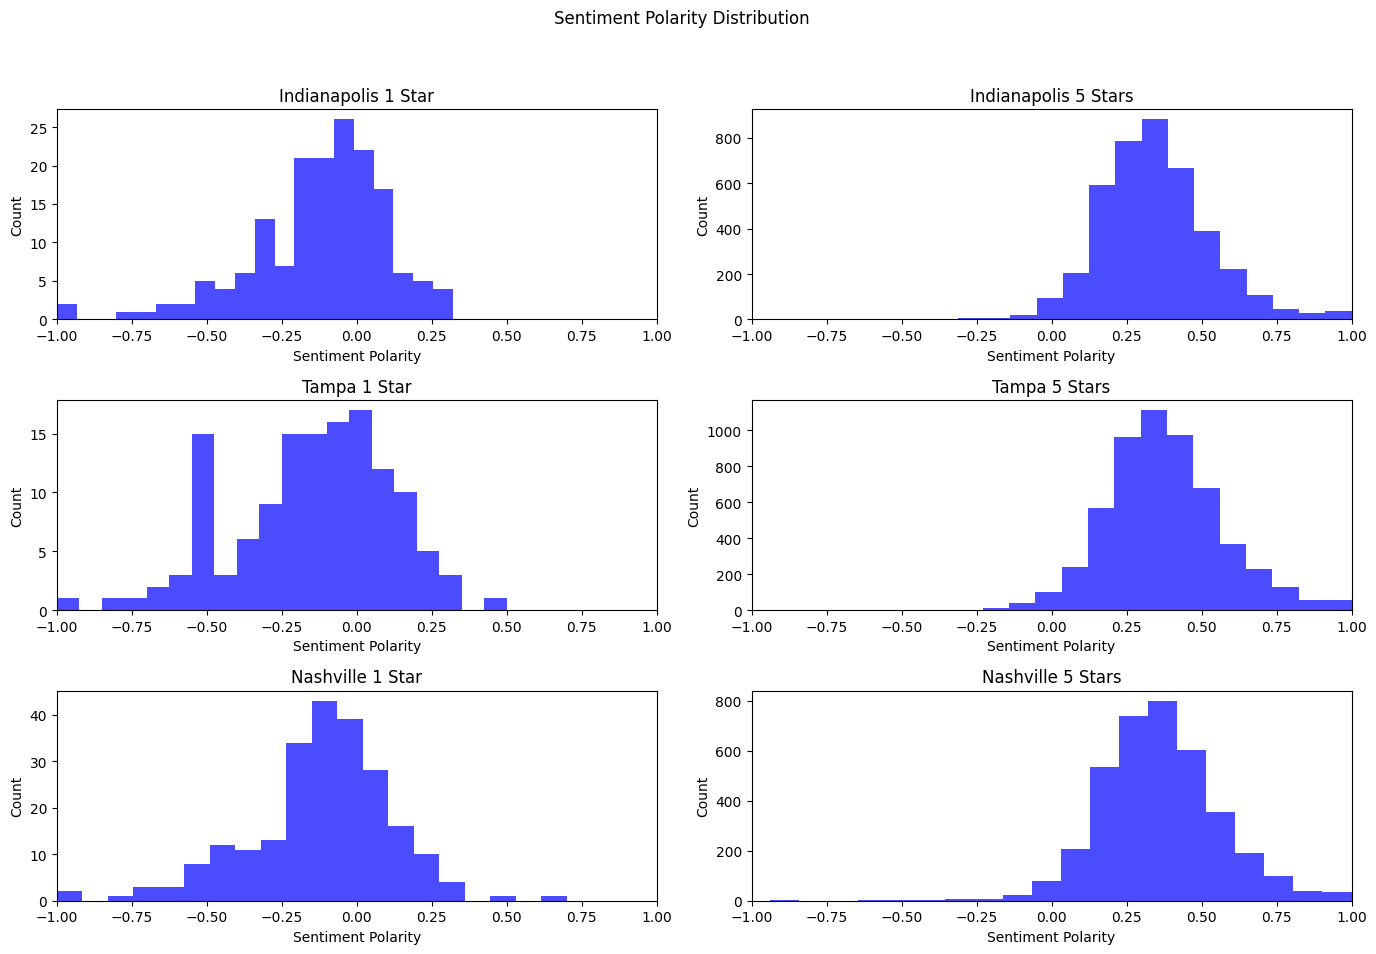

In [26]:
from textblob import TextBlob
import pandas as pd
import matplotlib.pyplot as plt

# Assume 1-star and 5-star reviews for each city have been filtered and loaded into the following DataFrames:
# indianapolis_1_star_df, indianapolis_5_stars_df, tampa_1_star_reviews_df,
# tampa_5_star_reviews_df, nashville_1_star_reviews_df, nashville_5_star_reviews_df

# Define sentiment analysis function
def analyze_sentiment_polarity(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# Apply sentiment analysis to each DataFrame
dfs = {
    'Indianapolis 1 Star': indianapolis_1_star_reviews_df,
    'Indianapolis 5 Stars': indianapolis_5_star_reviews_df,
    'Tampa 1 Star': tampa_1_star_reviews_df,
    'Tampa 5 Stars': tampa_5_star_reviews_df,
    'Nashville 1 Star': nashville_1_star_reviews_df,
    'Nashville 5 Stars': nashville_5_star_reviews_df
}

for name, df in dfs.items():
    df['sentiment_polarity'] = df['text'].apply(analyze_sentiment_polarity)

# Calculate and print the average sentiment polarity for each DataFrame
for name, df in dfs.items():
    avg_sentiment = df['sentiment_polarity'].mean()
    print(f"{name} Average Sentiment Polarity: {avg_sentiment}")

# Visualize the distribution of sentiment polarity
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 10))
fig.suptitle('Sentiment Polarity Distribution')

for ax, (name, df) in zip(axes.flatten(), dfs.items()):
    ax.hist(df['sentiment_polarity'], bins=20, color='blue', alpha=0.7)
    ax.set_title(name)
    ax.set_xlim(-1, 1)
    ax.set_xlabel('Sentiment Polarity')
    ax.set_ylabel('Count')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [27]:
!pip install wordcloud

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Indianapolis Positive Reviews WordCloud:


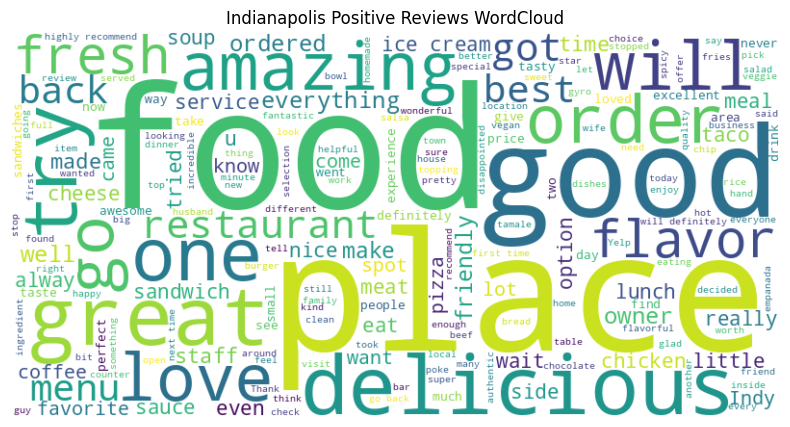


Indianapolis Negative Reviews WordCloud:


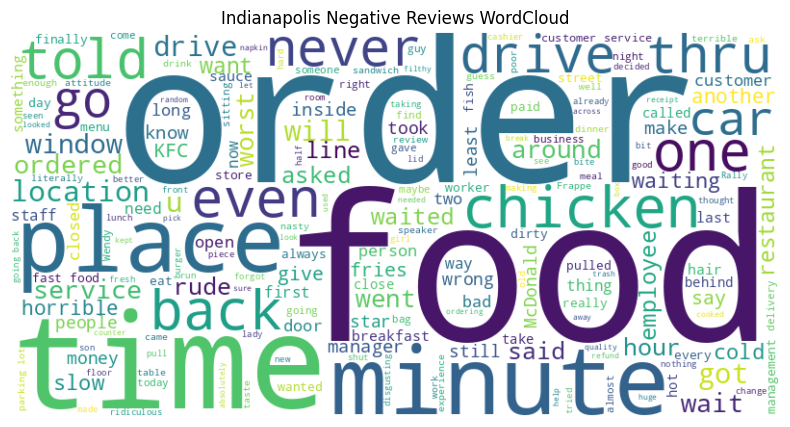


Nashville Positive Reviews WordCloud:


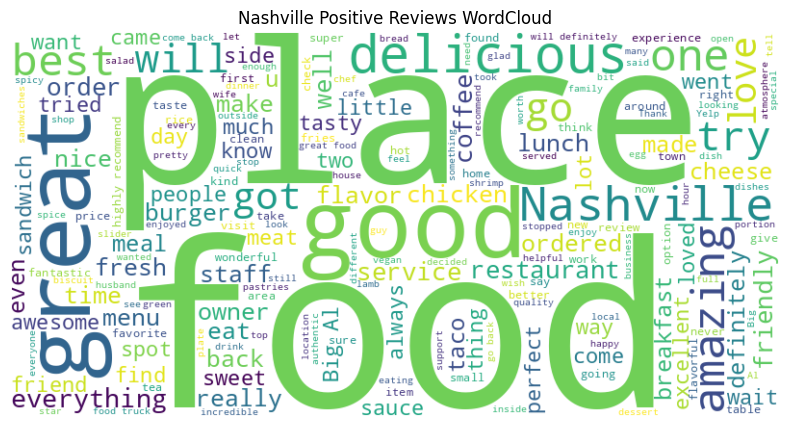


Nashville Negative Reviews WordCloud:


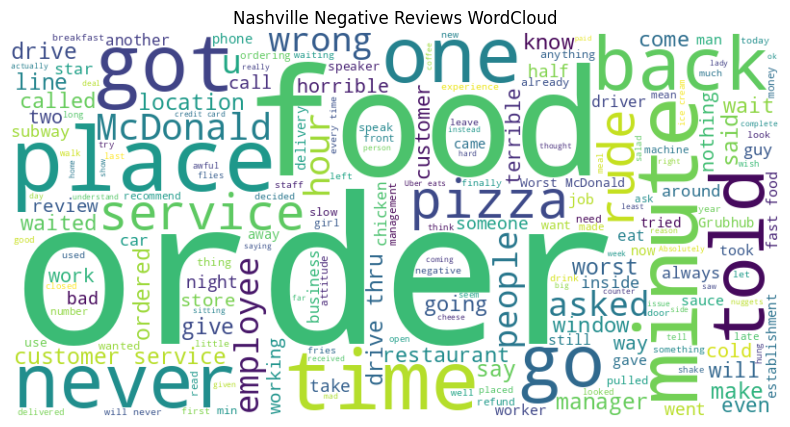


Tampa Positive Reviews WordCloud:


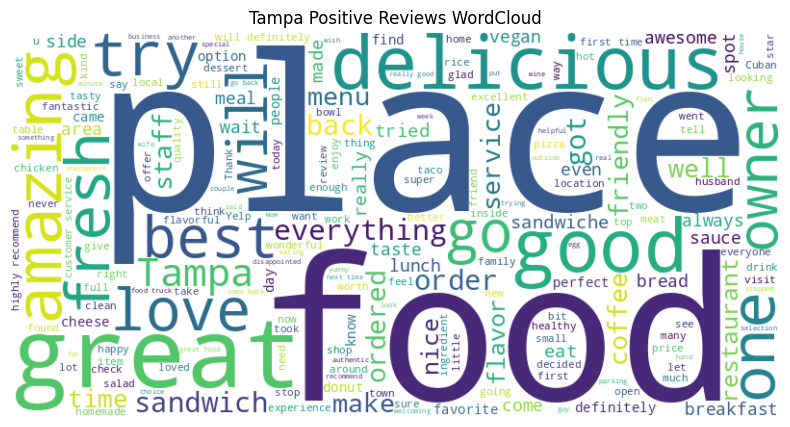


Tampa Negative Reviews WordCloud:


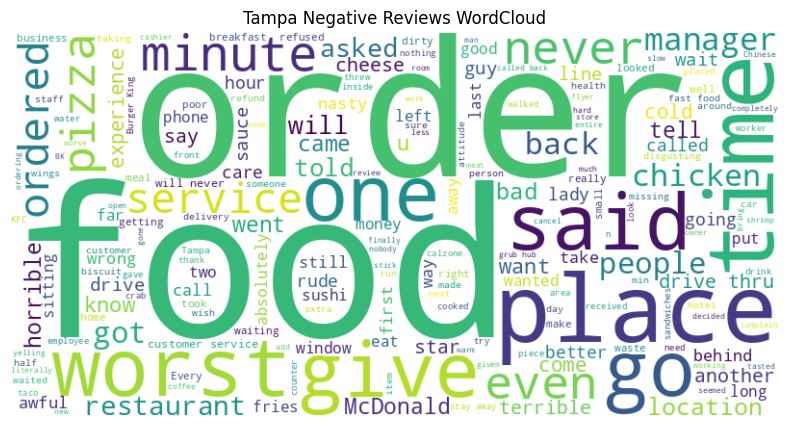

In [28]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# First, keep the word cloud generation function unchanged
def generate_wordcloud(text_series, title):
    long_text = ' '.join(text_series)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(long_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Then, generate word clouds for positive and negative comments for each city
cities = ['Indianapolis', 'Nashville', 'Tampa']
sentiments = ['Positive', 'Negative']

for city in cities:
    for sentiment in sentiments:
        if city == 'Indianapolis':
            df = indianapolis_5_star_reviews_df if sentiment == 'Positive' else indianapolis_1_star_reviews_df
        elif city == 'Nashville':
            df = nashville_5_star_reviews_df if sentiment == 'Positive' else nashville_1_star_reviews_df
        else:  # Tampa
            df = tampa_5_star_reviews_df if sentiment == 'Positive' else tampa_1_star_reviews_df

        text_series = df[df['sentiment'] == sentiment]['text']
        title = f"{city} {sentiment} Reviews WordCloud"
        print(f"\n{title}:")
        generate_wordcloud(text_series, title)

In [29]:
# Define a function to display sentiment analysis summaries
def display_sentiment_summary(df, city_name):
    sentiment_counts = df['sentiment'].value_counts(normalize=True) * 100
    print(f"Sentiment Summary for {city_name}:")
    print(sentiment_counts)

# Display sentiment analysis summaries for each city
display_sentiment_summary(indianapolis_5_star_reviews_df, "Indianapolis 5 Star Reviews")
display_sentiment_summary(indianapolis_1_star_reviews_df, "Indianapolis 1 Star Reviews")
display_sentiment_summary(nashville_5_star_reviews_df, "Nashville 5 Star Reviews")
display_sentiment_summary(nashville_1_star_reviews_df, "Nashville 1 Star Reviews")
display_sentiment_summary(tampa_5_star_reviews_df, "Tampa 5 Star Reviews")
display_sentiment_summary(tampa_1_star_reviews_df, "Tampa 1 Star Reviews")

Sentiment Summary for Indianapolis 5 Star Reviews:
sentiment
Positive    97.878049
Negative     1.682927
Neutral      0.439024
Name: proportion, dtype: float64
Sentiment Summary for Indianapolis 1 Star Reviews:
sentiment
Negative    68.484848
Positive    29.696970
Neutral      1.818182
Name: proportion, dtype: float64
Sentiment Summary for Nashville 5 Star Reviews:
sentiment
Positive    97.479217
Negative     2.145347
Neutral      0.375436
Name: proportion, dtype: float64
Sentiment Summary for Nashville 1 Star Reviews:
sentiment
Negative    65.502183
Positive    29.257642
Neutral      5.240175
Name: proportion, dtype: float64
Sentiment Summary for Tampa 5 Star Reviews:
sentiment
Positive    97.703436
Negative     1.826401
Neutral      0.470163
Name: proportion, dtype: float64
Sentiment Summary for Tampa 1 Star Reviews:
sentiment
Negative    70.370370
Positive    28.888889
Neutral      0.740741
Name: proportion, dtype: float64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
import nltk
nltk.download('vader_lexicon')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [31]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

nltk.download('vader_lexicon')

analyzer = SentimentIntensityAnalyzer()

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Define a function to perform sentiment analysis and assign labels
def perform_sentiment_analysis(df):
    df['sentiment_score'] = df['text'].apply(lambda review: analyzer.polarity_scores(review)['compound'])
    df['sentiment_label'] = df['sentiment_score'].apply(lambda score: 'positive' if score > 0.05 else ('negative' if score < -0.05 else 'neutral'))
    return df

# Perform sentiment analysis on each filtered dataset
datasets = [indianapolis_1_star_reviews_df, indianapolis_5_star_reviews_df, nashville_1_star_reviews_df, nashville_5_star_reviews_df, tampa_1_star_reviews_df, tampa_5_star_reviews_df]
for dataset in datasets:
    perform_sentiment_analysis(dataset)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
<ipython-input-31-75c70090a432>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment_score'] = df['text'].apply(lambda review: analyzer.polarity_scores(review)['compound'])
<ipython-input-31-75c70090a432>:14: SettingWithCopyWarning: 
A value is trying to be set o

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-32-411b6fda4b91>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment_label', data=dataset, palette='viridis')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/cat

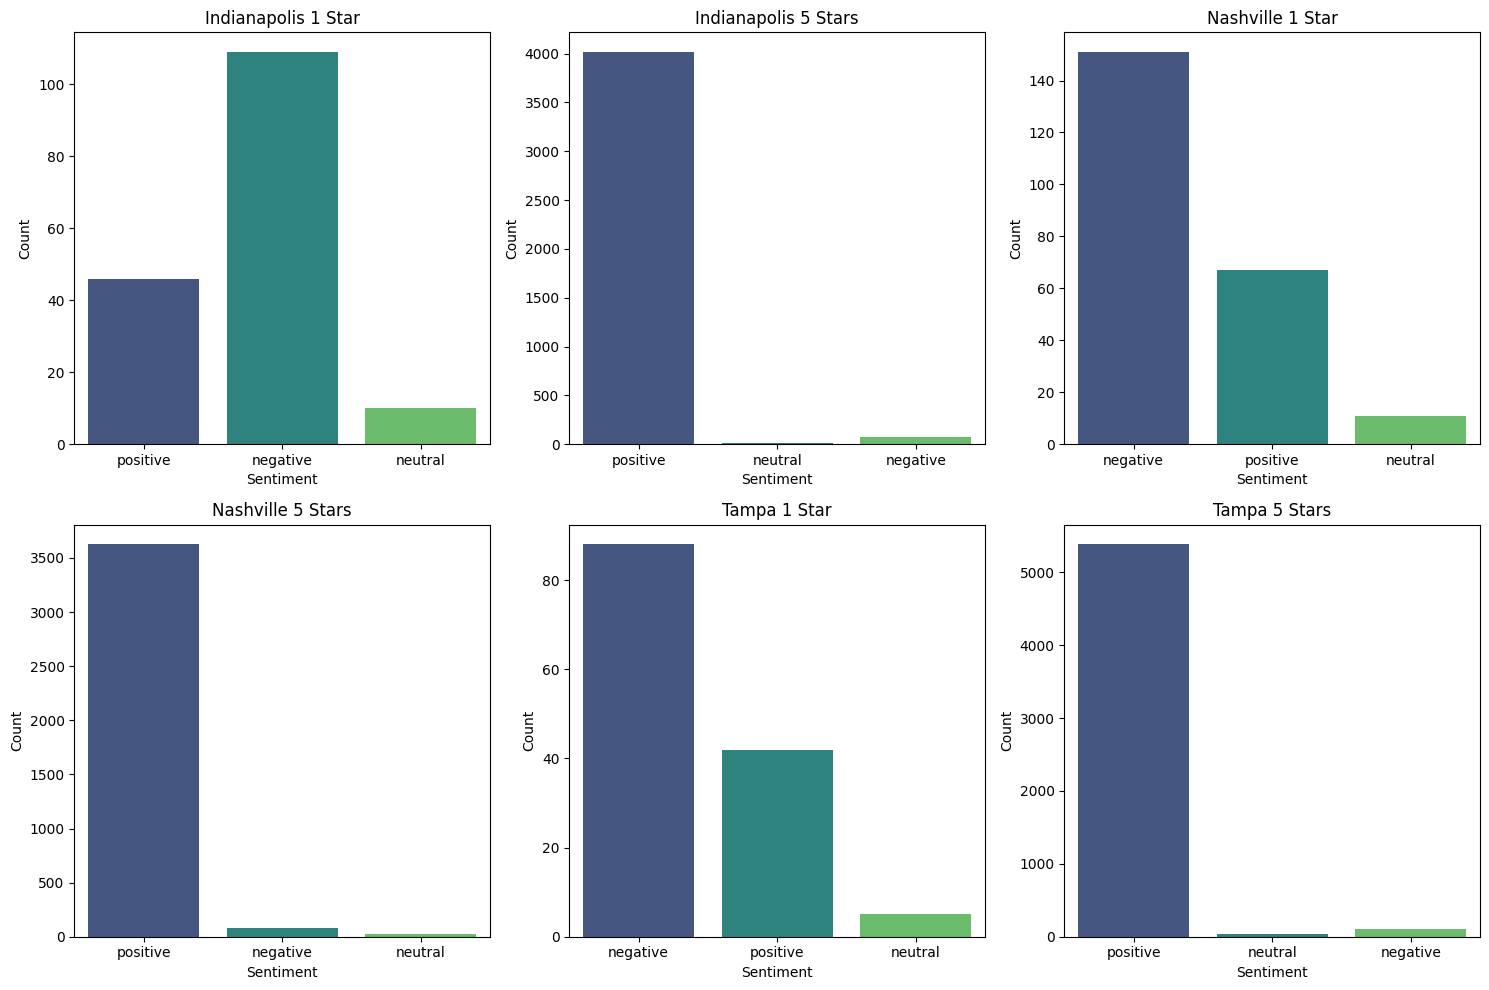

In [32]:
import seaborn as sns

def visualize_sentiment_distribution(datasets, titles):
    plt.figure(figsize=(15, 10))
    for i, dataset in enumerate(datasets, 1):
        plt.subplot(2, 3, i)
        sns.countplot(x='sentiment_label', data=dataset, palette='viridis')
        plt.title(titles[i-1])
        plt.xlabel('Sentiment')
        plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

titles = ['Indianapolis 1 Star', 'Indianapolis 5 Stars', 'Nashville 1 Star', 'Nashville 5 Stars', 'Tampa 1 Star', 'Tampa 5 Stars']
visualize_sentiment_distribution(datasets, titles)

In [33]:
def print_sentiment_statistics(datasets, titles):
    for dataset, title in zip(datasets, titles):
        print(f"{title} Average Sentiment Score: {dataset['sentiment_score'].mean():.2f}")

print_sentiment_statistics(datasets, titles)

Indianapolis 1 Star Average Sentiment Score: -0.26
Indianapolis 5 Stars Average Sentiment Score: 0.88
Nashville 1 Star Average Sentiment Score: -0.28
Nashville 5 Stars Average Sentiment Score: 0.87
Tampa 1 Star Average Sentiment Score: -0.27
Tampa 5 Stars Average Sentiment Score: 0.87


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Sentiment Model

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

def train_and_evaluate_model(X, y, model, model_name):
    # TF-IDF vectorization
    tfidf_vectorizer = TfidfVectorizer(max_features=1000)
    X_tfidf = tfidf_vectorizer.fit_transform(X)

    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

    # Train the model
    model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_test)
    print(f"{model_name} - Classification Report")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}\n")

datasets = {
    'Indianapolis 1 Star': indianapolis_1_star_reviews_df,
    'Indianapolis 5 Stars': indianapolis_5_star_reviews_df,
    'Nashville 1 Star': nashville_1_star_reviews_df,
    'Nashville 5 Stars': nashville_5_star_reviews_df,
    'Tampa 1 Star': tampa_1_star_reviews_df,
    'Tampa 5 Stars': tampa_5_star_reviews_df
}

models = {
    'Naïve Bayes': MultinomialNB(),
    'SVM': SVC(kernel='linear'),
    'Logistic Regression': LogisticRegression(max_iter=1000)
}

for model_name, model in models.items():
    print(f"--- {model_name} ---")
    for dataset_name, dataset in datasets.items():
        print(f"\n{dataset_name}")
        X = dataset['text']
        y = dataset['sentiment_label']
        train_and_evaluate_model(X, y, model, model_name)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be remo

--- Naïve Bayes ---

Indianapolis 1 Star
Naïve Bayes - Classification Report
              precision    recall  f1-score   support

    negative       0.67      1.00      0.80        22
     neutral       0.00      0.00      0.00         2
    positive       0.00      0.00      0.00         9

    accuracy                           0.67        33
   macro avg       0.22      0.33      0.27        33
weighted avg       0.44      0.67      0.53        33

Accuracy: 0.6666666666666666


Indianapolis 5 Stars


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension

Naïve Bayes - Classification Report
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        20
     neutral       0.00      0.00      0.00         3
    positive       0.97      1.00      0.99       797

    accuracy                           0.97       820
   macro avg       0.32      0.33      0.33       820
weighted avg       0.94      0.97      0.96       820

Accuracy: 0.9719512195121951


Nashville 1 Star
Naïve Bayes - Classification Report
              precision    recall  f1-score   support

    negative       0.70      1.00      0.82        32
     neutral       0.00      0.00      0.00         5
    positive       0.00      0.00      0.00         9

    accuracy                           0.70        46
   macro avg       0.23      0.33      0.27        46
weighted avg       0.48      0.70      0.57        46

Accuracy: 0.6956521739130435


Nashville 5 Stars


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension

Naïve Bayes - Classification Report
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        15
     neutral       0.00      0.00      0.00         3
    positive       0.98      1.00      0.99       728

    accuracy                           0.98       746
   macro avg       0.33      0.33      0.33       746
weighted avg       0.95      0.98      0.96       746

Accuracy: 0.9758713136729222


Tampa 1 Star
Naïve Bayes - Classification Report
              precision    recall  f1-score   support

    negative       0.63      1.00      0.77        17
     neutral       0.00      0.00      0.00         3
    positive       0.00      0.00      0.00         7

    accuracy                           0.63        27
   macro avg       0.21      0.33      0.26        27
weighted avg       0.40      0.63      0.49        27

Accuracy: 0.6296296296296297


Tampa 5 Stars


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension

Naïve Bayes - Classification Report
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        19
     neutral       0.00      0.00      0.00         4
    positive       0.98      1.00      0.99      1083

    accuracy                           0.98      1106
   macro avg       0.33      0.33      0.33      1106
weighted avg       0.96      0.98      0.97      1106

Accuracy: 0.9792043399638336

--- SVM ---

Indianapolis 1 Star
SVM - Classification Report
              precision    recall  f1-score   support

    negative       0.67      1.00      0.80        22
     neutral       0.00      0.00      0.00         2
    positive       0.00      0.00      0.00         9

    accuracy                           0.67        33
   macro avg       0.22      0.33      0.27        33
weighted avg       0.44      0.67      0.53        33

Accuracy: 0.6666666666666666


Indianapolis 5 Stars


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


SVM - Classification Report
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        20
     neutral       0.00      0.00      0.00         3
    positive       0.97      1.00      0.99       797

    accuracy                           0.97       820
   macro avg       0.32      0.33      0.33       820
weighted avg       0.94      0.97      0.96       820

Accuracy: 0.9719512195121951


Nashville 1 Star
SVM - Classification Report
              precision    recall  f1-score   support

    negative       0.70      1.00      0.82        32
     neutral       0.00      0.00      0.00         5
    positive       0.00      0.00      0.00         9

    accuracy                           0.70        46
   macro avg       0.23      0.33      0.27        46
weighted avg       0.48      0.70      0.57        46

Accuracy: 0.6956521739130435


Nashville 5 Stars


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension

SVM - Classification Report
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        15
     neutral       0.00      0.00      0.00         3
    positive       0.98      1.00      0.99       728

    accuracy                           0.98       746
   macro avg       0.33      0.33      0.33       746
weighted avg       0.95      0.98      0.96       746

Accuracy: 0.9758713136729222


Tampa 1 Star
SVM - Classification Report
              precision    recall  f1-score   support

    negative       0.63      1.00      0.77        17
     neutral       0.00      0.00      0.00         3
    positive       0.00      0.00      0.00         7

    accuracy                           0.63        27
   macro avg       0.21      0.33      0.26        27
weighted avg       0.40      0.63      0.49        27

Accuracy: 0.6296296296296297


Tampa 5 Stars


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension

SVM - Classification Report
              precision    recall  f1-score   support

    negative       1.00      0.05      0.10        19
     neutral       0.00      0.00      0.00         4
    positive       0.98      1.00      0.99      1083

    accuracy                           0.98      1106
   macro avg       0.66      0.35      0.36      1106
weighted avg       0.98      0.98      0.97      1106

Accuracy: 0.9801084990958409

--- Logistic Regression ---

Indianapolis 1 Star
Logistic Regression - Classification Report
              precision    recall  f1-score   support

    negative       0.67      1.00      0.80        22
     neutral       0.00      0.00      0.00         2
    positive       0.00      0.00      0.00         9

    accuracy                           0.67        33
   macro avg       0.22      0.33      0.27        33
weighted avg       0.44      0.67      0.53        33

Accuracy: 0.6666666666666666


Indianapolis 5 Stars


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension

Logistic Regression - Classification Report
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        20
     neutral       0.00      0.00      0.00         3
    positive       0.97      1.00      0.99       797

    accuracy                           0.97       820
   macro avg       0.32      0.33      0.33       820
weighted avg       0.94      0.97      0.96       820

Accuracy: 0.9719512195121951


Nashville 1 Star
Logistic Regression - Classification Report
              precision    recall  f1-score   support

    negative       0.70      1.00      0.82        32
     neutral       0.00      0.00      0.00         5
    positive       0.00      0.00      0.00         9

    accuracy                           0.70        46
   macro avg       0.23      0.33      0.27        46
weighted avg       0.48      0.70      0.57        46

Accuracy: 0.6956521739130435


Nashville 5 Stars


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension

Logistic Regression - Classification Report
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        15
     neutral       0.00      0.00      0.00         3
    positive       0.98      1.00      0.99       728

    accuracy                           0.98       746
   macro avg       0.33      0.33      0.33       746
weighted avg       0.95      0.98      0.96       746

Accuracy: 0.9758713136729222


Tampa 1 Star
Logistic Regression - Classification Report
              precision    recall  f1-score   support

    negative       0.63      1.00      0.77        17
     neutral       0.00      0.00      0.00         3
    positive       0.00      0.00      0.00         7

    accuracy                           0.63        27
   macro avg       0.21      0.33      0.26        27
weighted avg       0.40      0.63      0.49        27

Accuracy: 0.6296296296296297


Tampa 5 Stars
Logistic Regression - Classification Report
              pre

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension

#LDA

In [36]:
# Define the text preprocessing function
stop_words = stopwords.words('english')
def preprocess_text(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in stop_words and len(token) > 3:
            result.append(token)
    return result

# Apply the preprocessing to the 'text' column of the Indianapolis 5-star reviews DataFrame
processed_docs_indianapolis_5_star = indianapolis_5_star_reviews_df['text'].map(preprocess_text)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [37]:
# Create a dictionary from the processed documents
dictionary_indianapolis_5_star = corpora.Dictionary(processed_docs_indianapolis_5_star)

# Create a corpus from the dictionary
corpus_indianapolis_5_star = [dictionary_indianapolis_5_star.doc2bow(doc) for doc in processed_docs_indianapolis_5_star]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [38]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit + 1, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=dictionary,
                                                num_topics=num_topics,
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha='auto',
                                                per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

# Parameters for coherence value computation
limit = 30; start = 2; step = 2;

# Compute coherence values
model_list_indianapolis_5_star, coherence_values_indianapolis_5_star = compute_coherence_values(dictionary=dictionary_indianapolis_5_star, corpus=corpus_indianapolis_5_star, texts=processed_docs_indianapolis_5_star, start=start, limit=limit, step=step)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


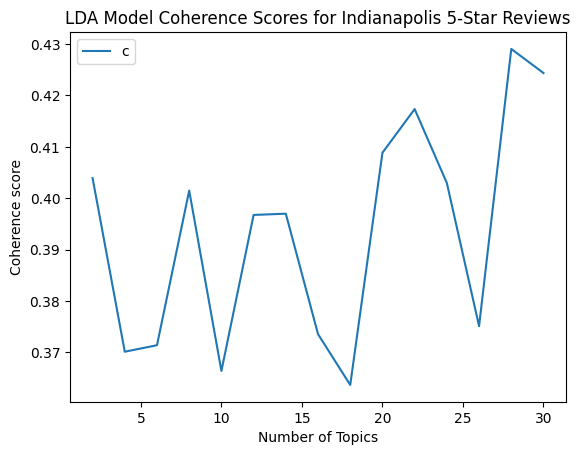

In [39]:
# Plotting coherence scores to find the optimal number of topics
x = range(start, limit + 1, step)
plt.plot(x, coherence_values_indianapolis_5_star)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.title("LDA Model Coherence Scores for Indianapolis 5-Star Reviews")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [40]:
import gensim

choice_of_k = 20

# Assuming processed_docs_indianapolis_5_star is already defined as shown in previous steps
dictionary = corpora.Dictionary(processed_docs_indianapolis_5_star)
corpus = [dictionary.doc2bow(doc) for doc in processed_docs_indianapolis_5_star]


# LDA model training
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=choice_of_k,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# Visualizing the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary)
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.341905  0.186924       1        1  41.739502
4     -0.332340  0.230253       2        1  19.413692
1     -0.221138 -0.300778       3        1   8.755737
18    -0.203006  0.024698       4        1   7.320951
2     -0.189738 -0.157914       5        1   5.072079
9     -0.081472 -0.118873       6        1   4.310235
0     -0.058976 -0.088240       7        1   3.367479
7      0.001051 -0.036267       8        1   2.454512
15     0.070065  0.004271       9        1   1.155748
12     0.079408  0.008522      10        1   1.090349
19     0.092784  0.014062      11        1   1.038622
5      0.097409  0.015824      12        1   0.969371
8      0.101740  0.017425      13        1   0.775344
10     0.125810  0.025108      14        1   0.716154
16     0.128583  0.025839      15        1   0.648422
17     0.124261  0.024706      16        1   0.476216
14     0.138556  0.028406      17        1   0.424909
13     0.146566  0.030155      18        1   0.214690
6      0.161478  0.033015      19        1   0.029895
11     0.160864  0.032865      20        1   0.026094, topic_info=             Term         Freq        Total Category  logprob  loglift
119          food  4629.000000  4629.000000  Default  30.0000  30.0000
64          great  2827.000000  2827.000000  Default  29.0000  29.0000
430         owner  1361.000000  1361.000000  Default  28.0000  28.0000
68     restaurant  1316.000000  1316.000000  Default  27.0000  27.0000
201       service   977.000000   977.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
2548        covid     0.003969     0.990052  Topic20  -9.3407   2.7321
10205      injera     0.003969     0.990212  Topic20  -9.3407   2.7319
348       history     0.003969     0.990114  Topic20  -9.3407   2.7320
2399    ethiopian     0.003970     0.991109  Topic20  -9.3406   2.7311
5758     ethiopia     0.003969     0.990211  Topic20  -9.3407   2.7319

[835 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0         6  0.996893        able
230       3  0.996045  absolutely
972       9  0.980307      actual
293      17  0.907507      adding
1398     10  0.949765      advice
...     ...       ...         ...
505       8  0.988749        year
439      13  0.992497       years
640       6  0.995981        yelp
1248     12  0.983183       young
1417      2  0.995991       yummy

[565 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 2, 19, 3, 10, 1, 8, 16, 13, 20, 6, 9, 11, 17, 18, 15, 14, 7, 12])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


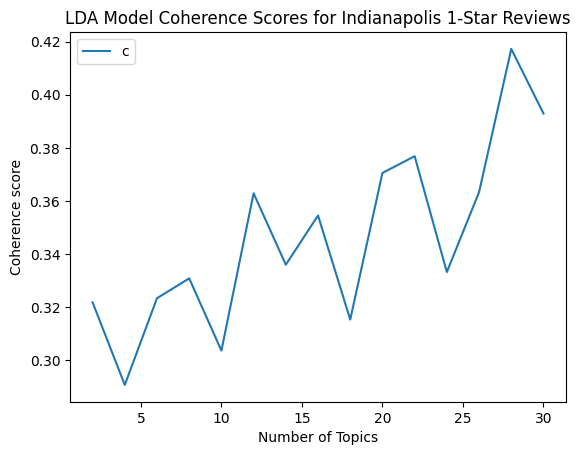

In [41]:
# Apply the preprocessing to the 'text' column of the Indianapolis 1-star reviews DataFrame
processed_docs_indianapolis_1_star = indianapolis_1_star_reviews_df['text'].map(preprocess_text)

# Create a dictionary from the processed documents for the 1-star reviews
dictionary_indianapolis_1_star = corpora.Dictionary(processed_docs_indianapolis_1_star)

# Create a corpus from the dictionary for the 1-star reviews
corpus_indianapolis_1_star = [dictionary_indianapolis_1_star.doc2bow(doc) for doc in processed_docs_indianapolis_1_star]

# No change needed here, the function is generic and can be used as is
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit + 1, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=dictionary,
                                                num_topics=num_topics,
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha='auto',
                                                per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

# Compute coherence values for the 1-star reviews
model_list_indianapolis_1_star, coherence_values_indianapolis_1_star = compute_coherence_values(dictionary=dictionary_indianapolis_1_star, corpus=corpus_indianapolis_1_star, texts=processed_docs_indianapolis_1_star, start=start, limit=limit, step=step)

# Plotting coherence scores to find the optimal number of topics for the 1-star reviews
plt.plot(x, coherence_values_indianapolis_1_star)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.title("LDA Model Coherence Scores for Indianapolis 1-Star Reviews")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [42]:
import gensim

choice_of_k = 20

# Assuming processed_docs_indianapolis_1_star is already defined as shown in previous steps
dictionary = corpora.Dictionary(processed_docs_indianapolis_1_star)
corpus = [dictionary.doc2bow(doc) for doc in processed_docs_indianapolis_1_star]


# LDA model training
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=choice_of_k,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# Visualizing the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary)
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
16     0.209944 -0.004181       1        1  16.931258
10     0.189175 -0.026145       2        1  10.938053
0      0.200170  0.113010       3        1  10.281559
17     0.050873 -0.117070       4        1   9.327883
18     0.111536  0.041962       5        1   7.483728
5      0.080060  0.031330       6        1   6.471269
6      0.021452 -0.016401       7        1   5.418526
2     -0.012120 -0.220069       8        1   5.308830
4     -0.041425 -0.100415       9        1   4.502584
8      0.037321  0.013934      10        1   4.471041
14    -0.023760  0.053531      11        1   3.566462
7     -0.155395  0.040851      12        1   3.224177
19    -0.074696  0.062262      13        1   2.656867
12    -0.046210 -0.001856      14        1   2.432935
13    -0.088750  0.020654      15        1   1.566866
1     -0.114694  0.043118      16        1   1.460658
3     -0.070607  0.023288      17        1   1.324124
15    -0.072103 -0.003361      18        1   1.118912
9     -0.093977  0.016000      19        1   0.952283
11    -0.106793  0.029559      20        1   0.561985, topic_info=        Term        Freq       Total Category  logprob  loglift
220    place   57.000000   57.000000  Default  30.0000  30.0000
9       food  103.000000  103.000000  Default  29.0000  29.0000
15   minutes   67.000000   67.000000  Default  28.0000  28.0000
207    would   58.000000   58.000000  Default  27.0000  27.0000
106  chicken   43.000000   43.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
145  manager    0.223991   22.924416  Topic20  -5.1317   0.5531
222     rude    0.272188   34.151812  Topic20  -4.9368   0.3494
171     said    0.223996   41.110956  Topic20  -5.1317  -0.0310
9       food    0.287573  103.531211  Topic20  -4.8818  -0.7047
98   another    0.015671   22.958329  Topic20  -7.7915  -2.1081

[1041 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
697       4  0.573482  absolutely
697       6  0.095580  absolutely
697      13  0.095580  absolutely
697      14  0.191161  absolutely
508       1  0.605379      across
...     ...       ...         ...
749      19  0.359753        year
346       5  0.660841       years
900      11  0.799535        yelp
924       1  0.684424   yesterday
864       3  0.885604        zero

[1486 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 11, 1, 18, 19, 6, 7, 3, 5, 9, 15, 8, 20, 13, 14, 2, 4, 16, 10, 12])

In [43]:
# Define the text preprocessing function
stop_words = stopwords.words('english')
def preprocess_text(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in stop_words and len(token) > 3:
            result.append(token)
    return result

# Apply the preprocessing to the 'text' column of the Indianapolis 5-star reviews DataFrame
processed_docs_nashville_5_star = nashville_5_star_reviews_df['text'].map(preprocess_text)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [44]:
# Create a dictionary from the processed documents
dictionary_nasville_5_star = corpora.Dictionary(processed_docs_nashville_5_star)

# Create a corpus from the dictionary
corpus_nashville_5_star = [dictionary_nasville_5_star.doc2bow(doc) for doc in processed_docs_nashville_5_star]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [45]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit + 1, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=dictionary,
                                                num_topics=num_topics,
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha='auto',
                                                per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

# Parameters for coherence value computation
limit = 30; start = 2; step = 2;

# Compute coherence values
model_list_nashville_5_star, coherence_values_nashville_5_star = compute_coherence_values(dictionary=dictionary_nasville_5_star, corpus=corpus_nashville_5_star, texts=processed_docs_nashville_5_star, start=start, limit=limit, step=step)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


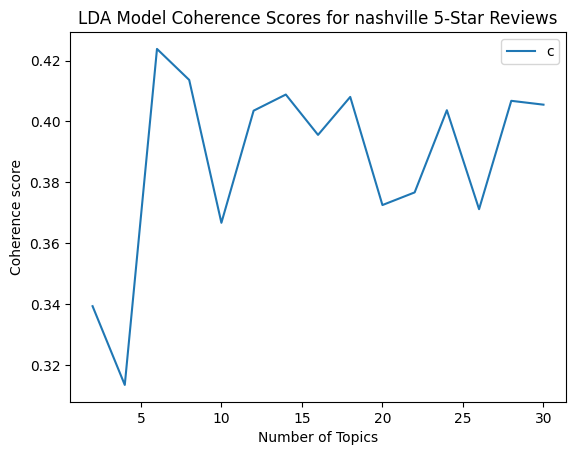

In [46]:
# Plotting coherence scores to find the optimal number of topics
x = range(start, limit + 1, step)
plt.plot(x, coherence_values_nashville_5_star)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.title("LDA Model Coherence Scores for nashville 5-Star Reviews")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [47]:
choice_of_k = 5

# Assuming processed_docs_nashville_5_star is already defined as shown in previous steps
dictionary = corpora.Dictionary(processed_docs_nashville_5_star)
corpus = [dictionary.doc2bow(doc) for doc in processed_docs_nashville_5_star]


# LDA model training
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=choice_of_k,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# Visualizing the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary)
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.299946  0.080354       1        1  53.330239
1      0.179224 -0.144673       2        1  20.931945
4     -0.133735  0.289066       3        1  14.050350
0     -0.195086 -0.149653       4        1   7.079005
2     -0.150349 -0.075093       5        1   4.608460, topic_info=          Term         Freq        Total Category  logprob  loglift
43        food  2902.000000  2902.000000  Default  30.0000  30.0000
1828     tacos   535.000000   535.000000  Default  29.0000  29.0000
123      great  1473.000000  1473.000000  Default  28.0000  28.0000
294   friendly   714.000000   714.000000  Default  27.0000  27.0000
151      truck   437.000000   437.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
1329    snacks    28.286782    29.079674   Topic5  -5.4110   3.0496
939       read    26.656389    27.426515   Topic5  -5.4704   3.0488
6059      horn    56.399257    58.324491   Topic5  -4.7209   3.0437
876    smaller    29.391635    30.243203   Topic5  -5.3727   3.0487
1750      cafe    83.127174   166.639808   Topic5  -4.3330   2.3818

[239 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
153       1  0.948312      also
153       2  0.038249      also
153       3  0.013189      also
210       2  0.998108    always
1         1  0.886010   amazing
...     ...       ...       ...
207       5  0.977491  whatever
647       5  0.978977     world
115       1  0.998965     would
1475      5  0.989506     wrong
674       2  0.997667     years

[273 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 5, 1, 3])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


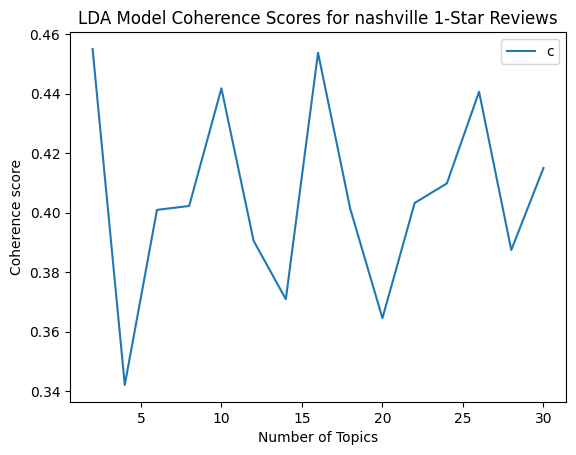

In [48]:
# Apply the preprocessing to the 'text' column of the nashville 1-star reviews DataFrame
processed_docs_nashville_1_star = nashville_1_star_reviews_df['text'].map(preprocess_text)

# Create a dictionary from the processed documents for the 1-star reviews
dictionary_nashville_1_star = corpora.Dictionary(processed_docs_nashville_1_star)

# Create a corpus from the dictionary for the 1-star reviews
corpus_nashville_1_star = [dictionary_nashville_1_star.doc2bow(doc) for doc in processed_docs_nashville_1_star]

# No change needed here, the function is generic and can be used as is
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit + 1, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=dictionary,
                                                num_topics=num_topics,
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha='auto',
                                                per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

# Compute coherence values for the 1-star reviews
model_list_nashville_1_star, coherence_values_nashville_1_star = compute_coherence_values(dictionary=dictionary_nashville_1_star, corpus=corpus_nashville_1_star, texts=processed_docs_nashville_1_star, start=start, limit=limit, step=step)

# Plotting coherence scores to find the optimal number of topics for the 1-star reviews
plt.plot(x, coherence_values_nashville_1_star)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.title("LDA Model Coherence Scores for nashville 1-Star Reviews")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [49]:
import gensim

choice_of_k = 17

# Assuming processed_docs_nashville_1_star is already defined as shown in previous steps
dictionary = corpora.Dictionary(processed_docs_nashville_1_star)
corpus = [dictionary.doc2bow(doc) for doc in processed_docs_nashville_1_star]


# LDA model training
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=choice_of_k,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# Visualizing the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary)
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11     0.382044 -0.026677       1        1  61.394904
3      0.118733  0.251549       2        1  11.150586
1      0.017738 -0.152691       3        1   7.016373
15     0.107472 -0.136593       4        1   6.508090
4     -0.012054  0.021190       5        1   3.414979
10    -0.079353 -0.005482       6        1   2.175990
12    -0.054164 -0.004486       7        1   1.399050
7     -0.068544  0.001974       8        1   1.337525
0     -0.046564  0.012672       9        1   1.235298
2     -0.059012  0.009001      10        1   1.145186
16    -0.049239  0.005699      11        1   0.820609
6     -0.055090  0.007637      12        1   0.791654
8     -0.053308  0.009497      13        1   0.665799
14    -0.045319  0.001188      14        1   0.560876
5     -0.035616  0.002708      15        1   0.156987
13    -0.034591  0.001442      16        1   0.127659
9     -0.033133  0.001372      17        1   0.098436, topic_info=          Term        Freq       Total Category  logprob  loglift
147      order  215.000000  215.000000  Default  30.0000  30.0000
513  mcdonalds   35.000000   35.000000  Default  29.0000  29.0000
15        mins   22.000000   22.000000  Default  28.0000  28.0000
34      people   54.000000   54.000000  Default  27.0000  27.0000
404    waiting   34.000000   34.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
36       still    0.003751   33.438732  Topic17  -7.7115  -2.1720
365     inside    0.003751   21.756296  Topic17  -7.7115  -1.7421
213       told    0.003751   43.996085  Topic17  -7.7115  -2.4463
19     service    0.003751   93.193041  Topic17  -7.7115  -3.1969
179       come    0.003751   22.510469  Topic17  -7.7115  -1.7762

[756 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
414       3  0.862083     absolute
344       1  0.662556   absolutely
344      10  0.220852   absolutely
787       5  0.681548      account
1018      2  0.760371  acknowledge
...     ...       ...          ...
604       5  0.072179        years
768      14  0.848704         yelp
967       3  0.976719        young
380       2  0.606297      younger
380      10  0.606297      younger

[601 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 4, 2, 16, 5, 11, 13, 8, 1, 3, 17, 7, 9, 15, 6, 14, 10])

In [50]:
# Define the text preprocessing function
stop_words = stopwords.words('english')
def preprocess_text(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in stop_words and len(token) > 3:
            result.append(token)
    return result

# Apply the preprocessing to the 'text' column of the Tampa 5-star reviews DataFrame
processed_docs_tampa_5_star = tampa_5_star_reviews_df['text'].map(preprocess_text)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [51]:
# Create a dictionary from the processed documents
dictionary_tampa_5_star = corpora.Dictionary(processed_docs_tampa_5_star)

# Create a corpus from the dictionary
corpus_tampa_5_star = [dictionary_tampa_5_star.doc2bow(doc) for doc in processed_docs_tampa_5_star]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [52]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit + 1, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=dictionary,
                                                num_topics=num_topics,
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha='auto',
                                                per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

# Parameters for coherence value computation
limit = 30; start = 2; step = 2;

# Compute coherence values
model_list_tampa_5_star, coherence_values_tampa_5_star = compute_coherence_values(dictionary=dictionary_tampa_5_star, corpus=corpus_tampa_5_star, texts=processed_docs_tampa_5_star, start=start, limit=limit, step=step)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


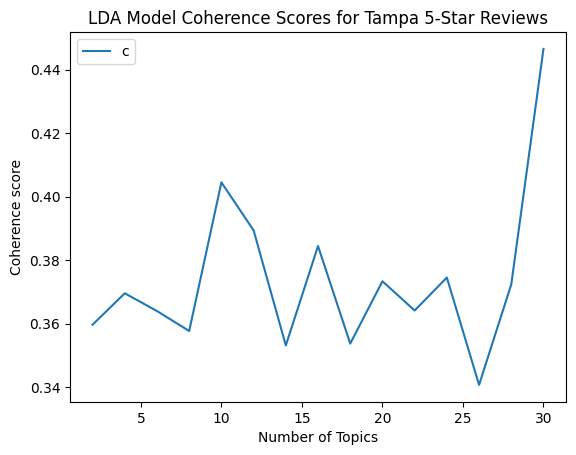

In [53]:
# Plotting coherence scores to find the optimal number of topics
x = range(start, limit + 1, step)
plt.plot(x, coherence_values_tampa_5_star)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.title("LDA Model Coherence Scores for Tampa 5-Star Reviews")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [54]:
import gensim

choice_of_k = 30

# Assuming processed_docs_tampa_5_star is already defined as shown in previous steps
dictionary = corpora.Dictionary(processed_docs_tampa_5_star)
corpus = [dictionary.doc2bow(doc) for doc in processed_docs_tampa_5_star]


# LDA model training
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=choice_of_k,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# Visualizing the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary)
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
29    -0.354117 -0.204466       1        1  30.436667
21    -0.346301 -0.237714       2        1  18.940740
27    -0.234698  0.269750       3        1  10.810656
3     -0.179212  0.211480       4        1   7.012503
13    -0.083857  0.096640       5        1   3.082976
25    -0.027144  0.030380       6        1   2.252765
1     -0.036391  0.045678       7        1   2.151462
10    -0.029115  0.039376       8        1   2.023456
0     -0.007816  0.022431       9        1   1.966527
4     -0.009438  0.023670      10        1   1.952292
5     -0.002308  0.018264      11        1   1.924068
17    -0.049026  0.057523      12        1   1.837323
12    -0.022897  0.034842      13        1   1.765601
23     0.041848 -0.007408      14        1   1.174318
22     0.039121 -0.006343      15        1   1.171140
11     0.053181 -0.013331      16        1   1.166920
16     0.066473 -0.019192      17        1   1.037294
18     0.058513 -0.015719      18        1   1.022392
26     0.048440 -0.010891      19        1   0.938129
28     0.074073 -0.022391      20        1   0.913796
14     0.086923 -0.027222      21        1   0.802858
20     0.096736 -0.030597      22        1   0.761225
6      0.088758 -0.027842      23        1   0.727006
15     0.083474 -0.025945      24        1   0.720528
24     0.084038 -0.026097      25        1   0.672013
9      0.092547 -0.029142      26        1   0.627146
7      0.112648 -0.035471      27        1   0.601099
2      0.101554 -0.032153      28        1   0.569030
19     0.118148 -0.036948      29        1   0.564324
8      0.135848 -0.041164      30        1   0.373748, topic_info=         Term         Freq        Total Category  logprob  loglift
310      best  1753.000000  1753.000000  Default   30.000  30.0000
20   friendly  1660.000000  1660.000000  Default   29.000  29.0000
526     vegan  1485.000000  1485.000000  Default   28.000  28.0000
24      great  3492.000000  3492.000000  Default   27.000  27.0000
173  sandwich  2508.000000  2508.000000  Default   26.000  26.0000
..        ...          ...          ...      ...      ...      ...
22    getting     0.030719   237.354795  Topic30  -10.102  -3.3631
23       gone     0.030719    43.141325  Topic30  -10.102  -1.6580
24      great     0.030719  3492.096329  Topic30  -10.102  -6.0518
25       half     0.030719   110.727939  Topic30  -10.102  -2.6006
26     hearty     0.030719    36.667903  Topic30  -10.102  -1.4954

[1231 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
347      25  0.941222       absolute
183       2  0.997877     absolutely
0        16  0.989970  accommodating
1127      6  0.997317         across
703       4  0.995777       actually
...     ...       ...            ...
679      23  0.992149          years
307       1  0.997746           yelp
1081      8  0.979348      yesterday
308      18  0.978660          young
182      27  0.995427          yummy

[620 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[30, 22, 28, 4, 14, 26, 2, 11, 1, 5, 6, 18, 13, 24, 23, 12, 17, 19, 27, 29, 15, 21, 7, 16, 25, 10, 8, 3, 20, 9])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


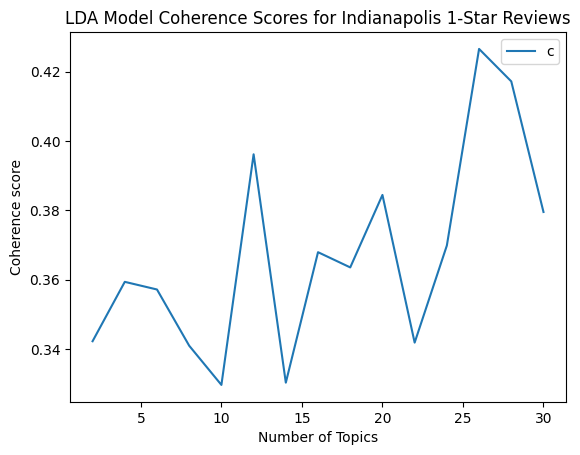

In [55]:
# Apply the preprocessing to the 'text' column of the tampa 1-star reviews DataFrame
processed_docs_tampa_1_star = tampa_1_star_reviews_df['text'].map(preprocess_text)

# Create a dictionary from the processed documents for the 1-star reviews
dictionary_tampa_1_star = corpora.Dictionary(processed_docs_tampa_1_star)

# Create a corpus from the dictionary for the 1-star reviews
corpus_tampa_1_star = [dictionary_tampa_1_star.doc2bow(doc) for doc in processed_docs_tampa_1_star]

# No change needed here, the function is generic and can be used as is
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit + 1, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=dictionary,
                                                num_topics=num_topics,
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha='auto',
                                                per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

# Compute coherence values for the 1-star reviews
model_list_tampa_1_star, coherence_values_tampa_1_star = compute_coherence_values(dictionary=dictionary_tampa_1_star, corpus=corpus_tampa_1_star, texts=processed_docs_tampa_1_star, start=start, limit=limit, step=step)

# Plotting coherence scores to find the optimal number of topics for the 1-star reviews
plt.plot(x, coherence_values_tampa_1_star)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.title("LDA Model Coherence Scores for Indianapolis 1-Star Reviews")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [56]:
import gensim

choice_of_k = 27

# Assuming processed_docs_tampa_1_star is already defined as shown in previous steps
dictionary = corpora.Dictionary(processed_docs_tampa_1_star)
corpus = [dictionary.doc2bow(doc) for doc in processed_docs_tampa_1_star]


# LDA model training
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=choice_of_k,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# Visualizing the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary)
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
21     0.236833 -0.175726       1        1  22.779863
8      0.252332 -0.049053       2        1  16.067986
4      0.263764  0.160620       3        1   7.944691
11     0.116045  0.079432       4        1   5.789743
19    -0.020464  0.183953       5        1   5.232874
2      0.013103 -0.086198       6        1   3.741661
18    -0.069775  0.000974       7        1   3.719061
1      0.042660 -0.025166       8        1   2.939994
10    -0.006623 -0.099838       9        1   2.932643
20     0.025360  0.099094      10        1   2.744835
25    -0.054565 -0.080022      11        1   2.696005
5     -0.023317 -0.018068      12        1   2.674384
23    -0.031163 -0.031991      13        1   2.486438
0     -0.036530  0.016669      14        1   2.435085
22    -0.001072 -0.010821      15        1   2.239717
7     -0.084910  0.012402      16        1   2.177109
17     0.034802  0.033602      17        1   2.018932
26    -0.038436  0.000794      18        1   1.925138
14    -0.039439  0.004670      19        1   1.720606
6     -0.050796 -0.016283      20        1   1.444201
13    -0.043651 -0.023255      21        1   1.281931
3     -0.067560  0.012237      22        1   1.014291
24    -0.096098 -0.005030      23        1   0.787080
16    -0.070265  0.010412      24        1   0.658691
12    -0.095933  0.003981      25        1   0.460742
15    -0.077145  0.001299      26        1   0.043313
9     -0.077159  0.001312      27        1   0.042986, topic_info=           Term        Freq       Total Category  logprob  loglift
633       pizza   56.000000   56.000000  Default  30.0000  30.0000
33        order  129.000000  129.000000  Default  29.0000  29.0000
595  restaurant   33.000000   33.000000  Default  28.0000  28.0000
430       phone   19.000000   19.000000  Default  27.0000  27.0000
364        call   15.000000   15.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
111       check    0.001396    5.664519  Topic27  -7.3969  -0.5566
108       wings    0.001396    7.082809  Topic27  -7.3969  -0.7801
987      stated    0.001396    5.100856  Topic27  -7.3969  -0.4518
290       sauce    0.001396   10.265064  Topic27  -7.3969  -1.1511
291      saying    0.001396    7.443654  Topic27  -7.3969  -0.8298

[1267 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
567       2  0.546907  absolutely
567       4  0.328144  absolutely
894      17  0.708250      absurd
1060      4  0.700906    actually
1060     13  0.233635    actually
...     ...       ...         ...
992      13  0.165456        york
312       9  0.334600       young
312      14  0.669200       young
824       6  0.468212        zero
824      11  0.468212        zero

[1176 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[22, 9, 5, 12, 20, 3, 19, 2, 11, 21, 26, 6, 24, 1, 23, 8, 18, 27, 15, 7, 14, 4, 25, 17, 13, 16, 10])

#Overview Result

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


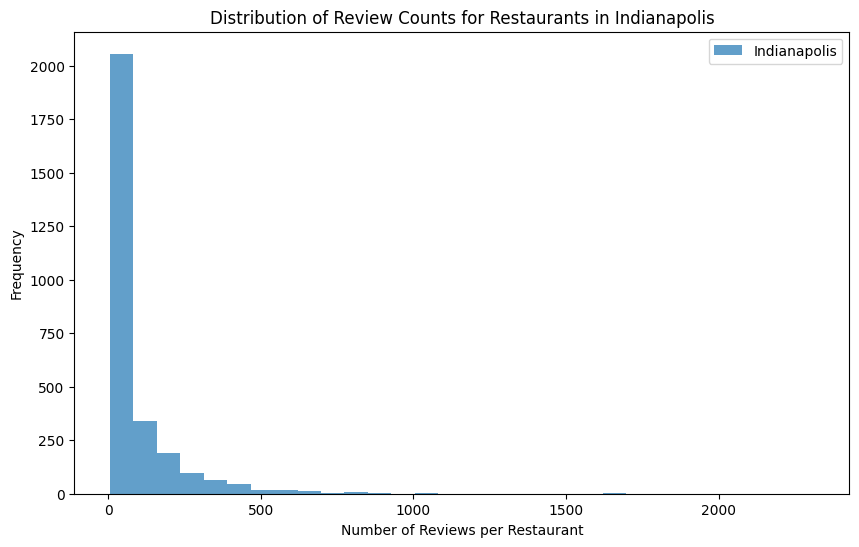

In [57]:
import matplotlib.pyplot as plt

# Example: Histogram of review counts for Indianapolis restaurants
indianapolis_review_counts = indianapolis_restaurants_reviews_df['business_id'].value_counts()
plt.figure(figsize=(10, 6))
plt.hist(indianapolis_review_counts, bins=30, alpha=0.7, label='Indianapolis')
plt.xlabel('Number of Reviews per Restaurant')
plt.ylabel('Frequency')
plt.title('Distribution of Review Counts for Restaurants in Indianapolis')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


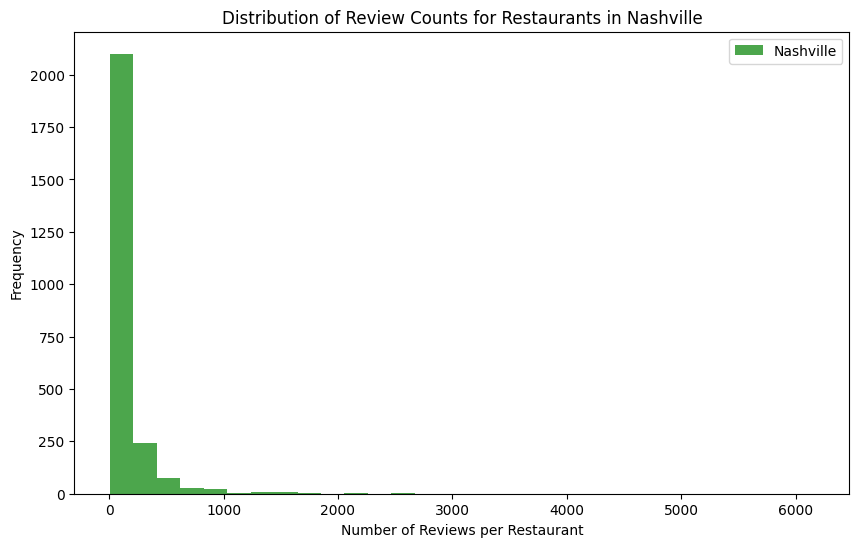

In [58]:
# Histogram of review counts for Nashville restaurants
nashville_review_counts = nashville_restaurants_reviews_df['business_id'].value_counts()
plt.figure(figsize=(10, 6))
plt.hist(nashville_review_counts, bins=30, alpha=0.7, color='green', label='Nashville')
plt.xlabel('Number of Reviews per Restaurant')
plt.ylabel('Frequency')
plt.title('Distribution of Review Counts for Restaurants in Nashville')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


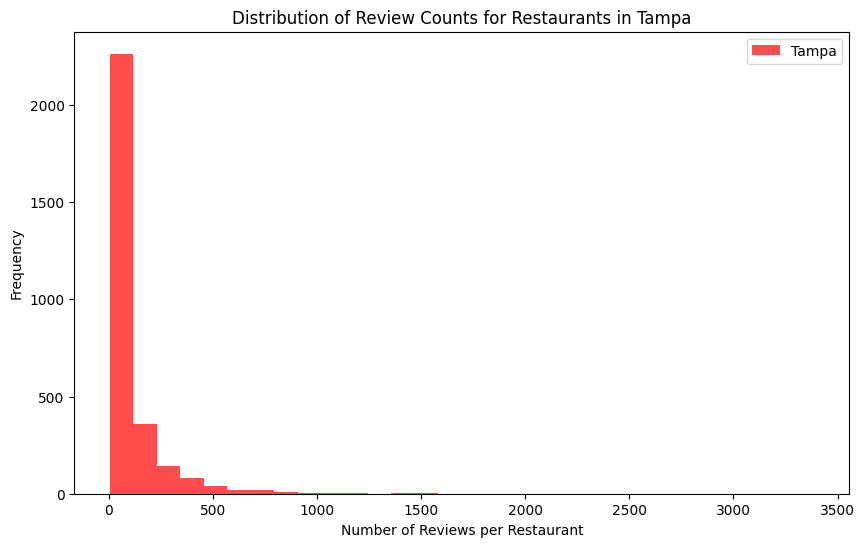

In [59]:
# Histogram of review counts for Tampa restaurants
tampa_review_counts = tampa_restaurants_reviews_df['business_id'].value_counts()
plt.figure(figsize=(10, 6))
plt.hist(tampa_review_counts, bins=30, alpha=0.7, color='red', label='Tampa')
plt.xlabel('Number of Reviews per Restaurant')
plt.ylabel('Frequency')
plt.title('Distribution of Review Counts for Restaurants in Tampa')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


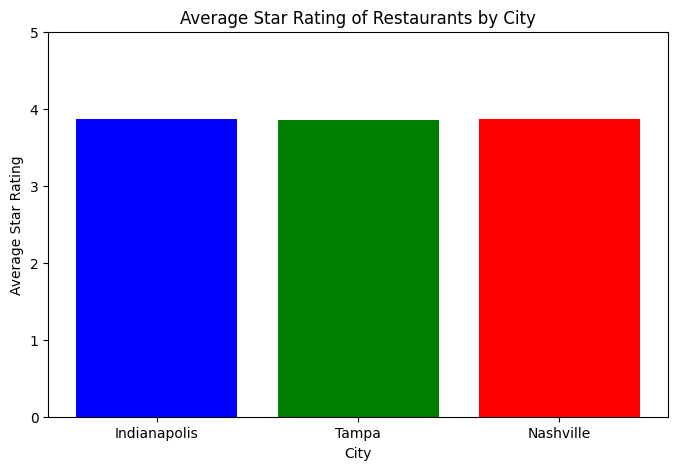

In [60]:
# Calculating average star rating for each city
avg_star_indianapolis = indianapolis_restaurants_reviews_df['stars_x'].mean()
avg_star_tampa = tampa_restaurants_reviews_df['stars_x'].mean()
avg_star_nashville = nashville_restaurants_reviews_df['stars_x'].mean()

cities = ['Indianapolis', 'Tampa', 'Nashville']
avg_stars = [avg_star_indianapolis, avg_star_tampa, avg_star_nashville]

plt.figure(figsize=(8, 5))
plt.bar(cities, avg_stars, color=['blue', 'green', 'red'])
plt.xlabel('City')
plt.ylabel('Average Star Rating')
plt.title('Average Star Rating of Restaurants by City')
plt.ylim(0, 5)
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-61-c4a175b834ac>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_reviews_indianapolis = indianapolis_restaurants_reviews_df.resample('M').size()


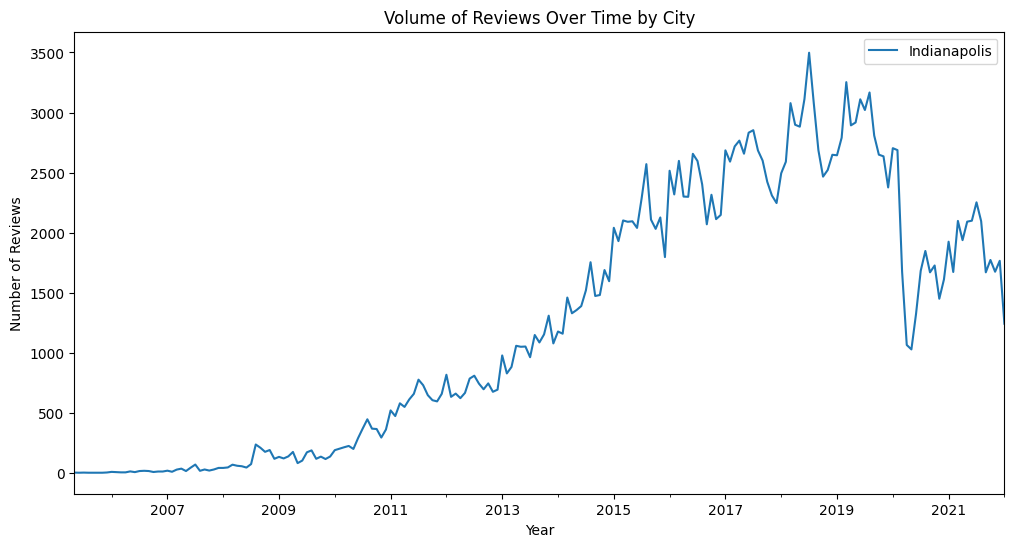

In [61]:
# Example: Plotting review volume over time for Indianapolis
indianapolis_restaurants_reviews_df.set_index('date', inplace=True)
monthly_reviews_indianapolis = indianapolis_restaurants_reviews_df.resample('M').size()

plt.figure(figsize=(12, 6))
monthly_reviews_indianapolis.plot(label='Indianapolis', legend=True)
# Repeat for Tampa and Nashville, and plot them on the same graph for comparison
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.title('Volume of Reviews Over Time by City')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-62-666189411177>:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_reviews_tampa = tampa_restaurants_reviews_df.resample('M').size()
<ipython-input-62-666189411177>:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_reviews_nashville = nashville_restaurants_reviews_df.resample('M').size()


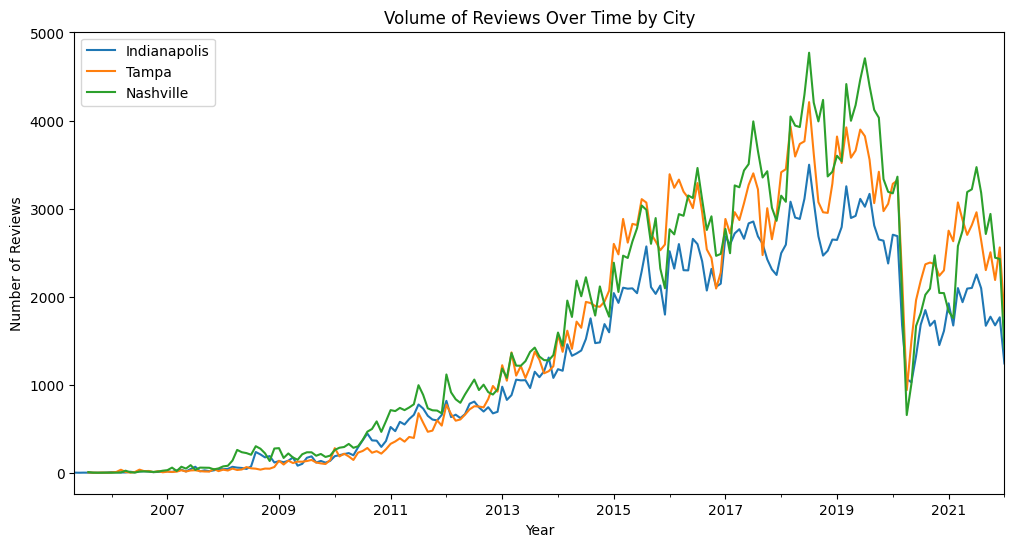

In [62]:
# Ensure 'date' is the datetime index for each DataFrame
tampa_restaurants_reviews_df['date'] = pd.to_datetime(tampa_restaurants_reviews_df['date'])
nashville_restaurants_reviews_df['date'] = pd.to_datetime(nashville_restaurants_reviews_df['date'])

tampa_restaurants_reviews_df.set_index('date', inplace=True)
nashville_restaurants_reviews_df.set_index('date', inplace=True)

# Resample and count reviews per month for each city
monthly_reviews_tampa = tampa_restaurants_reviews_df.resample('M').size()
monthly_reviews_nashville = nashville_restaurants_reviews_df.resample('M').size()

# Plotting
plt.figure(figsize=(12, 6))
monthly_reviews_indianapolis.plot(label='Indianapolis', legend=True)
monthly_reviews_tampa.plot(label='Tampa', legend=True)
monthly_reviews_nashville.plot(label='Nashville', legend=True)

plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.title('Volume of Reviews Over Time by City')
plt.legend()
plt.show()

In [ ]:
#@title Convert ipynb to HTML in Colab
# Upload ipynb
from google.colab import files
f = files.upload()

# Convert ipynb to html
import subprocess
file0 = list(f.keys())[0]
_ = subprocess.run(["pip", "install", "nbconvert"])
_ = subprocess.run(["jupyter", "nbconvert", file0, "--to", "html"])

# download the html
files.download(file0[:-5]+"html")